In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, precision_recall_curve
from sklearn.pipeline import Pipeline


In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1/main/Datasets/Train.csv')

In [3]:
df.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               8068 non-null   int64  
 1   Gender           8068 non-null   object 
 2   Ever_Married     7928 non-null   object 
 3   Age              8068 non-null   int64  
 4   Graduated        7990 non-null   object 
 5   Profession       7944 non-null   object 
 6   Work_Experience  7239 non-null   float64
 7   Spending_Score   8068 non-null   object 
 8   Family_Size      7733 non-null   float64
 9   Var_1            7992 non-null   object 
 10  Segmentation     8068 non-null   object 
dtypes: float64(2), int64(2), object(7)
memory usage: 693.5+ KB


In [5]:
df.describe(include='all')

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
count,8068.000000,8068,7928,8068.000000,7990,7944,7239.000000,8068,7733.000000,7992,8068
unique,NaN,2,2,NaN,2,9,NaN,3,NaN,7,4
top,NaN,Male,Yes,NaN,Yes,Artist,NaN,Low,NaN,Cat_6,D
freq,NaN,4417,4643,NaN,4968,2516,NaN,4878,NaN,5238,2268
mean,463479.214551,NaN,NaN,43.466906,NaN,NaN,2.641663,NaN,2.850123,NaN,NaN
std,2595.381232,NaN,NaN,16.711696,NaN,NaN,3.406763,NaN,1.531413,NaN,NaN
min,458982.000000,NaN,NaN,18.000000,NaN,NaN,0.000000,NaN,1.000000,NaN,NaN
25%,461240.750000,NaN,NaN,30.000000,NaN,NaN,0.000000,NaN,2.000000,NaN,NaN
50%,463472.500000,NaN,NaN,40.000000,NaN,NaN,1.000000,NaN,3.000000,NaN,NaN
75%,465744.250000,NaN,NaN,53.000000,NaN,NaN,4.000000,NaN,4.000000,NaN,NaN


In [6]:
# univariate analysis - first we check the output variable and make sure it's balanced
df.groupby('Segmentation').count()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1
Segmentation,,,,,,,,,,
A,1972,1972,1938,1972,1948,1939,1778,1972,1877,1953
B,1858,1858,1827,1858,1840,1836,1666,1858,1815,1845
C,1970,1970,1947,1970,1955,1952,1815,1970,1926,1949
D,2268,2268,2216,2268,2247,2217,1980,2268,2115,2245


In [7]:
df.columns

Index(['ID', 'Gender', 'Ever_Married', 'Age', 'Graduated', 'Profession',
       'Work_Experience', 'Spending_Score', 'Family_Size', 'Var_1',
       'Segmentation'],
      dtype='object')

<Axes: xlabel='Family_Size', ylabel='Count'>

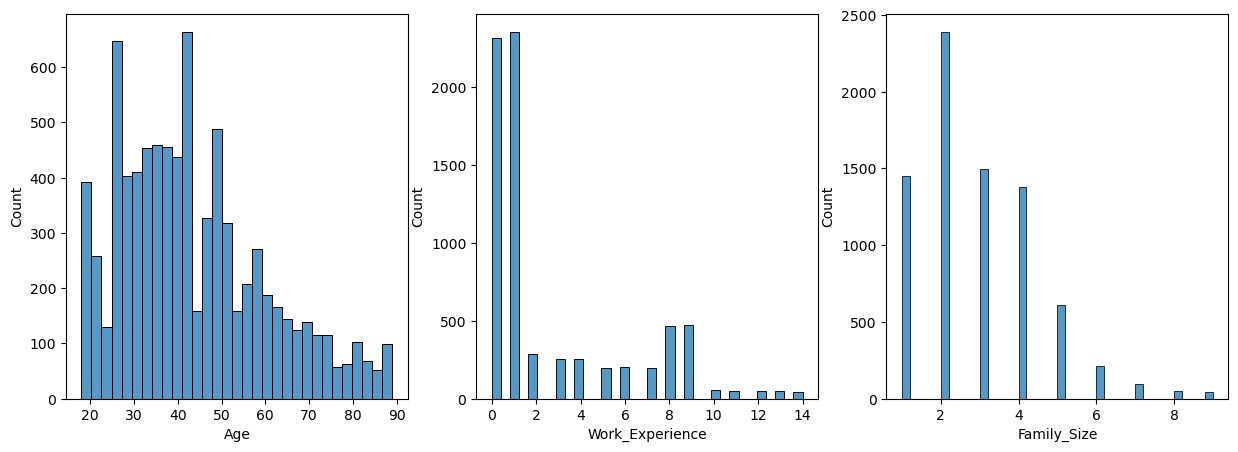

In [8]:
# check continuous variables distribution first > age, work experience, family size

import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,5))
sns.histplot(df['Age'], ax=ax1)
sns.histplot(df['Work_Experience'], ax=ax2)
sns.histplot(df['Family_Size'], ax=ax3)

# Boxplot Explanation
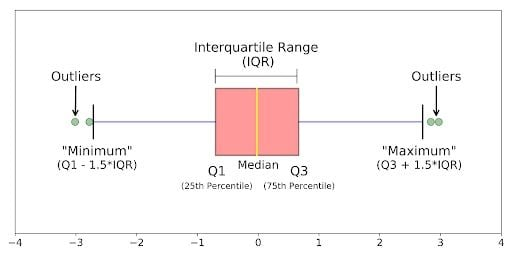

<Axes: xlabel='Segmentation', ylabel='Family_Size'>

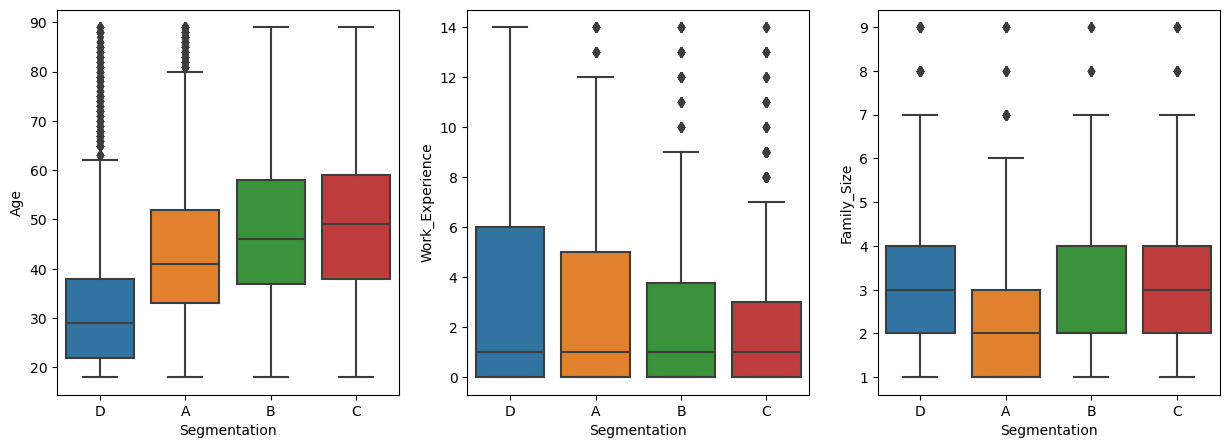

In [9]:
# check continuous variables first > age, work experience, family size > compare them to output variable

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,5))
sns.boxplot(x='Segmentation',y='Age', data=df, ax=ax1)
sns.boxplot(x='Segmentation',y='Work_Experience',data=df, ax=ax2)
sns.boxplot(x='Segmentation',y='Family_Size', data=df, ax=ax3)

## Initial Hypothesis
Age and work experience seem to be strong predictors of the segment

In [10]:
df.columns

Index(['ID', 'Gender', 'Ever_Married', 'Age', 'Graduated', 'Profession',
       'Work_Experience', 'Spending_Score', 'Family_Size', 'Var_1',
       'Segmentation'],
      dtype='object')

In [11]:
# get the counts of gender (values being the row index) over segmentation (values being the columns)
df.groupby(['Gender','Segmentation'])['ID'].count().unstack()

Segmentation,A,B,C,D
Gender,,,,
Female,909,861,922,959
Male,1063,997,1048,1309


In [12]:
df.groupby(['Ever_Married','Segmentation'])['ID'].count().unstack()

Segmentation,A,B,C,D
Ever_Married,,,,
No,801,479,398,1607
Yes,1137,1348,1549,609


In [13]:
df.groupby(['Graduated','Segmentation'])['ID'].count().unstack()

Segmentation,A,B,C,D
Graduated,,,,
No,729,508,348,1437
Yes,1219,1332,1607,810


In [14]:
df.groupby(['Profession','Segmentation'])['ID'].count().unstack()

Segmentation,A,B,C,D
Profession,,,,
Artist,558,756,1065,137
Doctor,199,143,140,206
Engineer,259,189,75,176
Entertainment,365,221,148,215
Executive,125,183,175,116
Healthcare,106,101,146,979
Homemaker,73,55,28,90
Lawyer,197,158,140,128
Marketing,57,30,35,170


In [15]:
for i in ['Gender', 'Ever_Married','Graduated', 'Profession','Spending_Score']:
    print(df.groupby([i,'Segmentation'])['ID'].count().unstack())

Segmentation     A    B     C     D
Gender                             
Female         909  861   922   959
Male          1063  997  1048  1309
Segmentation     A     B     C     D
Ever_Married                        
No             801   479   398  1607
Yes           1137  1348  1549   609
Segmentation     A     B     C     D
Graduated                           
No             729   508   348  1437
Yes           1219  1332  1607   810
Segmentation     A    B     C    D
Profession                        
Artist         558  756  1065  137
Doctor         199  143   140  206
Engineer       259  189    75  176
Entertainment  365  221   148  215
Executive      125  183   175  116
Healthcare     106  101   146  979
Homemaker       73   55    28   90
Lawyer         197  158   140  128
Marketing       57   30    35  170
Segmentation       A    B    C     D
Spending_Score                      
Average          343  590  903   138
High             271  384  405   156
Low             1358  884  

In [16]:
df[df['Segmentation']=='D'].describe(include='all')

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
count,2268.000000,2268,2216,2268.000000,2247,2217,1980.000000,2268,2115.000000,2245,2268
unique,NaN,2,2,NaN,2,9,NaN,3,NaN,7,1
top,NaN,Male,No,NaN,No,Healthcare,NaN,Low,NaN,Cat_6,D
freq,NaN,1309,1607,NaN,1437,979,NaN,1974,NaN,1297,2268
mean,463380.026896,NaN,NaN,33.390212,NaN,NaN,3.021717,NaN,3.232624,NaN,NaN
std,2605.525629,NaN,NaN,15.680304,NaN,NaN,3.622962,NaN,1.693600,NaN,NaN
min,458985.000000,NaN,NaN,18.000000,NaN,NaN,0.000000,NaN,1.000000,NaN,NaN
25%,461069.750000,NaN,NaN,22.000000,NaN,NaN,0.000000,NaN,2.000000,NaN,NaN
50%,463130.500000,NaN,NaN,29.000000,NaN,NaN,1.000000,NaN,3.000000,NaN,NaN
75%,465733.250000,NaN,NaN,38.000000,NaN,NaN,6.000000,NaN,4.000000,NaN,NaN


In [17]:
df[df['Segmentation']=='A'].describe(include='all')

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
count,1972.000000,1972,1938,1972.000000,1948,1939,1778.000000,1972,1877.000000,1953,1972
unique,NaN,2,2,NaN,2,9,NaN,3,NaN,7,1
top,NaN,Male,Yes,NaN,Yes,Artist,NaN,Low,NaN,Cat_6,A
freq,NaN,1063,1137,NaN,1219,558,NaN,1358,NaN,1213,1972
mean,463457.893002,NaN,NaN,44.924949,NaN,NaN,2.874578,NaN,2.439531,NaN,NaN
std,2585.220444,NaN,NaN,16.406909,NaN,NaN,3.603993,NaN,1.482015,NaN,NaN
min,458991.000000,NaN,NaN,18.000000,NaN,NaN,0.000000,NaN,1.000000,NaN,NaN
25%,461086.500000,NaN,NaN,33.000000,NaN,NaN,0.000000,NaN,1.000000,NaN,NaN
50%,463559.000000,NaN,NaN,41.000000,NaN,NaN,1.000000,NaN,2.000000,NaN,NaN
75%,465702.250000,NaN,NaN,52.000000,NaN,NaN,5.000000,NaN,3.000000,NaN,NaN


In [18]:
df[df['Segmentation']=='B'].describe(include='all')

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
count,1858.000000,1858,1827,1858.000000,1840,1836,1666.000000,1858,1815.000000,1845,1858
unique,NaN,2,2,NaN,2,9,NaN,3,NaN,7,1
top,NaN,Male,Yes,NaN,Yes,Artist,NaN,Low,NaN,Cat_6,B
freq,NaN,997,1348,NaN,1332,756,NaN,884,NaN,1232,1858
mean,463520.253498,NaN,NaN,48.200215,NaN,NaN,2.378151,NaN,2.696970,NaN,NaN
std,2550.208040,NaN,NaN,14.806443,NaN,NaN,3.225626,NaN,1.408615,NaN,NaN
min,458989.000000,NaN,NaN,18.000000,NaN,NaN,0.000000,NaN,1.000000,NaN,NaN
25%,461454.250000,NaN,NaN,37.000000,NaN,NaN,0.000000,NaN,2.000000,NaN,NaN
50%,463479.500000,NaN,NaN,46.000000,NaN,NaN,1.000000,NaN,2.000000,NaN,NaN
75%,465737.500000,NaN,NaN,58.000000,NaN,NaN,3.750000,NaN,4.000000,NaN,NaN


In [19]:
df[df['Segmentation']=='C'].describe(include='all')

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
count,1970.000000,1970,1947,1970.000000,1955,1952,1815.000000,1970,1926.000000,1949,1970
unique,NaN,2,2,NaN,2,9,NaN,3,NaN,7,1
top,NaN,Male,Yes,NaN,Yes,Artist,NaN,Average,NaN,Cat_6,C
freq,NaN,1048,1549,NaN,1607,1065,NaN,903,NaN,1496,1970
mean,463576.043655,NaN,NaN,49.144162,NaN,NaN,2.240771,NaN,2.974559,NaN,NaN
std,2633.377643,NaN,NaN,14.575090,NaN,NaN,3.046297,NaN,1.377322,NaN,NaN
min,458982.000000,NaN,NaN,18.000000,NaN,NaN,0.000000,NaN,1.000000,NaN,NaN
25%,461485.250000,NaN,NaN,38.000000,NaN,NaN,0.000000,NaN,2.000000,NaN,NaN
50%,463739.000000,NaN,NaN,49.000000,NaN,NaN,1.000000,NaN,3.000000,NaN,NaN
75%,465791.750000,NaN,NaN,59.000000,NaN,NaN,3.000000,NaN,4.000000,NaN,NaN


In [20]:
gender = pd.get_dummies(df['Gender'], dtype=int )

In [21]:
Ever_Married = pd.get_dummies(df['Ever_Married'], dtype=int)
Ever_Married.rename(columns={'Yes':"Married", "No":'Not_Married'})
Graduated = pd.get_dummies(df['Graduated'], dtype=int)
Graduated.rename(columns={"Yes":"Graduated", "No":"Not_Graduated"})
Profession = pd.get_dummies(df['Profession'], dtype=int)

In [22]:
Spending_score = pd.get_dummies(df['Spending_Score'], dtype=int)

In [23]:
df.columns

Index(['ID', 'Gender', 'Ever_Married', 'Age', 'Graduated', 'Profession',
       'Work_Experience', 'Spending_Score', 'Family_Size', 'Var_1',
       'Segmentation'],
      dtype='object')

In [24]:
new_df = pd.concat([df[['Age','Work_Experience','Family_Size']],gender,Ever_Married, Graduated, Profession, Spending_score, df['Segmentation']], axis=1)

In [25]:
new_df.dropna(inplace=True)

In [26]:
new_df.columns

Index(['Age', 'Work_Experience', 'Family_Size', 'Female', 'Male', 'No', 'Yes',
       'No', 'Yes', 'Artist', 'Doctor', 'Engineer', 'Entertainment',
       'Executive', 'Healthcare', 'Homemaker', 'Lawyer', 'Marketing',
       'Average', 'High', 'Low', 'Segmentation'],
      dtype='object')

In [27]:
new_df.iloc[:,21]

0       D
2       B
3       B
5       C
6       C
       ..
8063    D
8064    D
8065    D
8066    B
8067    B
Name: Segmentation, Length: 6969, dtype: object

In [28]:
knn = KNeighborsClassifier(n_neighbors=50)
knn.fit(np.array(new_df.iloc[:,:21]), np.array(new_df.iloc[:,21]))

KNeighborsClassifier(n_neighbors=50)

In [29]:
pred = knn.predict(np.array(new_df.iloc[:,:21]))

In [36]:
print("accuracy score: ",accuracy_score(pred, new_df.iloc[:,21]))
print("f1 score weighted: ",f1_score(pred, new_df.iloc[:,21],average='weighted'))
print("precision score weighted: ",precision_score(pred, new_df.iloc[:,21],average='weighted'))
print("recall score weighted: ",recall_score(pred, new_df.iloc[:,21],average='weighted'))

accuracy score:  0.507676854641986
f1 score weighted:  0.5214592723871236
precision score weighted:  0.5492298883877375
recall score weighted:  0.507676854641986


In [57]:
df.groupby(['Spending_Score','Segmentation'])['ID'].count().unstack()

Segmentation,A,B,C,D
Spending_Score,,,,
Average,343,590,903,138
High,271,384,405,156
Low,1358,884,662,1974


In [58]:
# Combine low value users which are in A & D into one category, and high value (B &C ) in another
def recategorization(x):
    if x == 'A':
        return 0
    elif x == 'D':
        return 0
    elif x == 'B':
        return 1
    elif x =='C':
        return 1
    

In [59]:
new_df['Segmentation'] = new_df['Segmentation'].apply(recategorization)

In [60]:
new_df

,Age,Work_Experience,Family_Size,Female,Male,No,Yes,No,Yes,Artist,...,Entertainment,Executive,Healthcare,Homemaker,Lawyer,Marketing,Average,High,Low,Segmentation
0,22,1.0,4.0,0,1,1,0,1,0,0,...,0,0,1,0,0,0,0,0,1,0
2,67,1.0,1.0,1,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,1,1
3,67,0.0,2.0,0,1,0,1,0,1,0,...,0,0,0,0,1,0,0,1,0,1
5,56,0.0,2.0,0,1,0,1,1,0,1,...,0,0,0,0,0,0,1,0,0,1
6,32,1.0,3.0,0,1,1,0,0,1,0,...,0,0,1,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8063,22,0.0,7.0,0,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
8064,35,3.0,4.0,0,1,1,0,1,0,0,...,0,1,0,0,0,0,0,0,1,0
8065,33,1.0,1.0,1,0,1,0,0,1,0,...,0,0,1,0,0,0,0,0,1,0
8066,27,1.0,4.0,1,0,1,0,0,1,0,...,0,0,1,0,0,0,0,0,1,1


In [61]:
knn = KNeighborsClassifier(n_neighbors=50)
knn.fit(np.array(new_df.iloc[:,:21]), np.array(new_df.iloc[:,21]))
pred = knn.predict(np.array(new_df.iloc[:,:21]))


0.7375520160711724


In [62]:
print(accuracy_score(pred, new_df.iloc[:,21]))
print(f1_score(pred, new_df.iloc[:,21]))
print(recall_score(pred, new_df.iloc[:,21]))
print(precision_score(pred, new_df.iloc[:,21]))

0.7375520160711724
0.7403095271901179
0.7177863436123348
0.7642919964819701


In [66]:
log = LogisticRegression()
nb = GaussianNB()
knn = KNeighborsClassifier()
svc = SVC()


In [68]:
X_train, X_test, y_train, y_test = train_test_split(np.array(new_df.iloc[:,:21]), np.array(new_df.iloc[:,21]), test_size=0.2, random_state=123)

In [70]:
log.fit(X_train, y_train)
nb.fit(X_train, y_train)
knn.fit(X_train, y_train)
svc.fit(X_train, y_train)

/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


SVC()

In [71]:
pred_l = log.predict(X_test)
pred_nb = nb.predict(X_test)
pred_knn = knn.predict(X_test)
pred_svc = svc.predict(X_test)

In [72]:
print(f1_score(pred_l, y_test))
print(f1_score(pred_nb, y_test))
print(f1_score(pred_knn, y_test))
print(f1_score(pred_svc, y_test))

0.7498197548666186
0.7309782608695653
0.7239692522711391
0.7124087591240876


In [73]:
pred_l_prob = log.predict_proba(X_test)


In [75]:
fpr, tpr, thresholds = roc_curve(y_test, pred_l_prob[:,1])

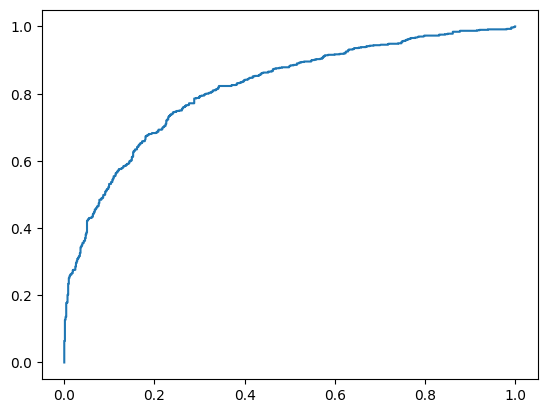

In [76]:
plt.plot(fpr, tpr)

In [77]:
gmeans = np.sqrt(tpr*(1-fpr))
gmeans

array([0.        , 0.03779645, 0.12535663, 0.13627703, 0.14638501,
       0.15583874, 0.20701967, 0.22038927, 0.25354628, 0.25336354,
       0.26167274, 0.27235762, 0.27496397, 0.28010393, 0.28515126,
       0.29011078, 0.30915428, 0.31373459, 0.33570005, 0.33992286,
       0.35025721, 0.35430656, 0.35631398, 0.35605681, 0.36786299,
       0.3675971 , 0.37525619, 0.3790277 , 0.40794649, 0.41141844,
       0.41486133, 0.41827588, 0.41997275, 0.41966875, 0.42135757,
       0.42105212, 0.42440717, 0.42773591, 0.44718828, 0.44686364,
       0.46549088, 0.46852343, 0.47898617, 0.4819338 , 0.48158343,
       0.49889132, 0.49852809, 0.50416136, 0.50379376, 0.50658488,
       0.50797469, 0.50723258, 0.50999681, 0.51099883, 0.51062406,
       0.51879456, 0.51841352, 0.5197618 , 0.518614  , 0.52793515,
       0.5275451 , 0.53669774, 0.53630063, 0.54145748, 0.54105625,
       0.54742934, 0.54702308, 0.54828788, 0.54788038, 0.55165457,
       0.55124396, 0.55374395, 0.55333117, 0.56075876, 0.56034

In [79]:
thresholds[np.argmax(gmeans)]

0.49967302476669934

In [90]:
knn_params = {'n_neighbors':range(50,300)}

rs_knn = RandomizedSearchCV(knn, knn_params, n_iter=10, cv=5, scoring='f1')
rs_knn.fit(X_train,y_train)
rs_knn.best_estimator_

KNeighborsClassifier(n_neighbors=72)

In [86]:
svc_params = {'kernel':['linear','poly','rbf']}

rs_svc = RandomizedSearchCV(svc, svc_params, n_iter=3, cv=5, scoring='f1')
rs_svc.fit(X_train, y_train)
rs_svc.best_estimator_

SVC(kernel='linear')

In [91]:
svc_best = SVC(kernel='linear')
knn_best = KNeighborsClassifier(n_neighbors=72)

svc_best.fit(X_train,y_train)
knn_best.fit(X_train,y_train)

pred_svc_best = svc_best.predict(X_test)
pred_knn_best = knn_best.predict(X_test)

print(f1_score(pred_svc_best, y_test))
print(f1_score(pred_knn_best, y_test))

0.7503526093088857
0.7286821705426358


In [89]:
print(f1_score(pred_l, y_test))


0.7498197548666186
